# Lesson 5 Assignment - Automobile Price Hypothesis Sim
## Author - Nourhan El Zarif

# Set Up 

In [1]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.stats
from matplotlib import pyplot as plt
import statsmodels.stats.power as ssp
%matplotlib inline

In [3]:
def read_auto_data(fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"):
    'Function to load the auto price data set from a .csv file' 

    ## Read the .csv file with the pandas read_csv method
    auto_price = pd.read_csv(fileName)
    
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_price.loc[auto_price[column] == '?', column] = np.nan
    auto_price.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_price[column] = pd.to_numeric(auto_price[column])
        
    return auto_price
auto_price = read_auto_data()

# Part 1: Identify a likely distribution for price and several other features.

## Identifying the Distribution of Price
We can visualize the price distribution of autos by plotting the data. A simple histogram can show that the distribution of price is not normal. We will test the distribution with lognormal and exponential distributions.

Text(0, 0.5, 'Frequency')

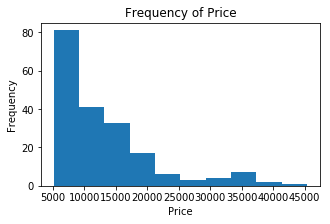

In [4]:
ax = plt.figure(figsize = (5,3)).gca()
plt.hist(auto_price.loc[:,'price'])
ax.set_title('Frequency of Price')
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')

Price vs Log Normal Distribution:<br>
The Q-Q plot of price/lognormal distribution shows many points that do ot align with the diagonal line. There are many outliers. The price does not fit a Log normal model.

Price vs Exponential Distribution:<br>
The Q-Q plot of price/exponential distribution shows that the first two quartiles align with the diagonal lines, but the remaining three quartiles don't. The price resembles but does not fit an exponential distribution.

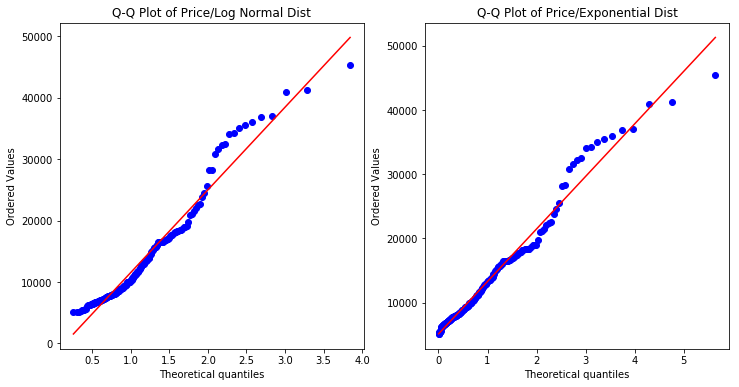

In [5]:
ax=plt.figure(figsize=(12,6)).gca()
plt.subplot(1,2,1)
ss.probplot(auto_price.loc[:, 'price'], dist=ss.lognorm(s=0.5) ,plot=plt)
plt.title('Q-Q Plot of Price/Log Normal Dist')

plt.subplot(1,2,2)
ss.probplot(auto_price.loc[:, 'price'], dist=ss.expon ,plot=plt)
plt.title('Q-Q Plot of Price/Exponential Dist')
plt.show()

## Identifying the Distribution of Curb-Weight
The histogram of the curb weight shows adistribution that appears to be normal.

Text(0, 0.5, 'Frequency')

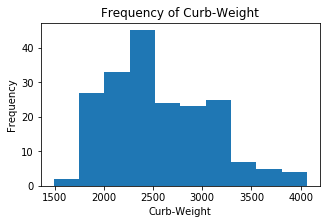

In [6]:
ax = plt.figure(figsize = (5,3)).gca()
plt.hist(auto_price.loc[:,'curb-weight'])
ax.set_title('Frequency of Curb-Weight')
ax.set_xlabel('Curb-Weight')
ax.set_ylabel('Frequency')

Curb Weight vs Normal Distribution:<br>
The Q-Q plot on the left shows many instances where the points do not align along the diagonal line, and the distance is fairly large too. The curb weight does not fit a normal distribution. 

Curb Weight vs Log Normal Distribution:<br>
The Q-Q plot on the right shows the points lying closer to the diagonal line. There are fewer outliers. The curb weight may have a Log Normal Distribution.

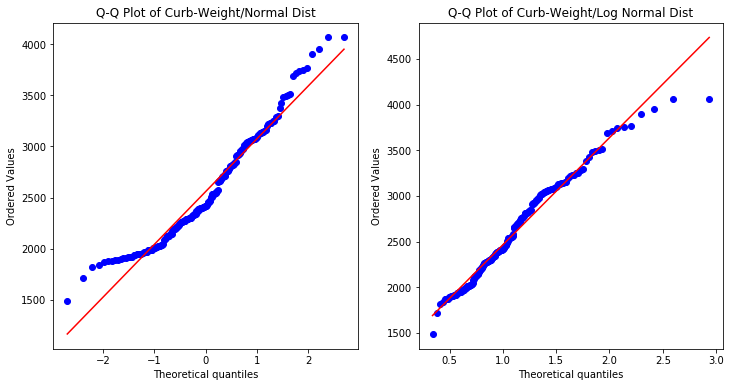

In [7]:
ax=plt.figure(figsize=(12,6)).gca()
plt.subplot(1,2,1)
ss.probplot(auto_price.loc[:, 'curb-weight'], plot=plt)
plt.title('Q-Q Plot of Curb-Weight/Normal Dist')

plt.subplot(1,2,2)
ss.probplot(auto_price.loc[:, 'curb-weight'], dist=ss.lognorm(s=0.4), plot=plt)
plt.title('Q-Q Plot of Curb-Weight/Log Normal Dist')
plt.show()

# Part 2-4: Compute basic summary statistics & confidence intervals & determine if the differences in pairs and multiple populations are significant

## Testing Significance Helper Functions

In [8]:
#We want a large sample to get a good representation of the population, but there are only 195 rows. 
#I will stratify the data, and make the size of the sample equal to the size of the smallest strata.
def stratify_by(df, group):
    #getting the size of the type with the lowest count
    size = df[group].value_counts().min()
    print('The sample size of each strata in ' + str(group) + ' is ' + str(size))
    
    groups = df.groupby([group])
    return groups.apply(lambda x: x.sample(n=size))


In [9]:
def t_test(a, b, alpha, alternative='two-sided'):
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

In [10]:
%matplotlib inline
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histogram of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [11]:
def plot_hist(x, p=5):
    # Plot the distribution and mark the mean
    plt.hist(x, alpha=.5)
    plt.axvline(x.mean())
    # 95% confidence interval    
    plt.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    plt.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)
    
def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    breaks = np.linspace(
        combined.min(), 
        combined.max(), 
        num=nbins+1)

    plt.subplot(2, 1, 1)
    plot_hist(a)
    plt.title(a_label)
    
    plt.subplot(2, 1, 2)
    plot_hist(b)
    plt.title(b_label)
    
    plt.tight_layout()

In [12]:
def comp_like(p, x): 
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()


def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity


def plot_post(prior, like, post, x):
    maxy = max(max(prior), max(like), max(post))
    plt.figure(figsize=(12, 4))
    plt.plot(x, like, label='likelihood', linewidth=12, color='black', alpha=.2)
    plt.plot(x, prior, label='prior')
    plt.plot(x, post, label='posterior', color='green')
    plt.ylim(0, maxy)
    plt.xlim(0, 1)
    plt.title('Density of prior, likelihood and posterior')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.legend()
    
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, lower_q, upper_q))

# Aspiration
This data is stratified by aspiration, standard and turbo. The three tests below demonstrate how we can have different outcomes based on the test we run.

## T-Test (Classical)

In [13]:
#stratifying the data
aspiration_strata = stratify_by(auto_price, 'aspiration')
aspiration_strata.reset_index(inplace = True, drop=True)

# I will drop all columns except for aspiration and price
aspiration_strata = aspiration_strata[['aspiration', 'price']]

The sample size of each strata in aspiration is 36


In [14]:
#creating seperate objects to pass to functions
std = aspiration_strata.loc[aspiration_strata.loc[:,'aspiration']=='std','price']
turbo = aspiration_strata.loc[aspiration_strata.loc[:,'aspiration']=='turbo','price']

Based on the t-test below, we cannot reject the null hypothesis that aspiration has no significant effect on price. The p-value is greater than 0.05, and the 95% confidence interval straddles 0. The t-statistic is also not big. 

The histogram below also demostrates this. The mean of the std aspiration is within the 95% confidence interval.

DegFreedom      61.173348
Difference    3458.666667
Statistic        1.869952
PValue           0.066278
Low95CI       -239.629350
High95CI      7156.962683
dtype: float64


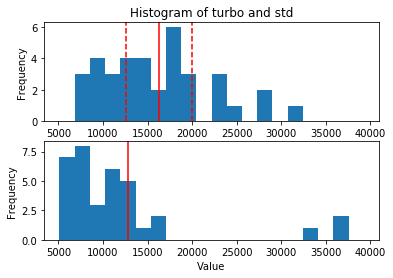

In [15]:
test = t_test(turbo, std, 0.05)
print(test)
plot_t(turbo, std, test, cols = ['turbo', 'std'])

## Bootstrap
Bootstrap on the other hand, shows a different result than the T-test

In [16]:
std = auto_price.loc[auto_price.loc[:, 'aspiration'] == 'std',:]
turbo = auto_price.loc[auto_price.loc[:, 'aspiration'] == 'turbo',:]

In [17]:
n = 1000

std_boot_mean = pd.Series([
    std.sample(frac=1, replace=True).price.mean()
    for i in range(n)
])

turbo_boot_mean = pd.Series([
    turbo.sample(frac=1, replace = True).price.mean()
    for i in range(n)
])

The two histograms below show that the confidence intervals for std and turbo aspiration do nt overlap. 

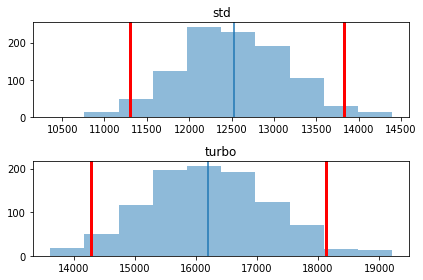

In [18]:
plot_dists(std_boot_mean, turbo_boot_mean, nbins=80, a_label='std', b_label='turbo')

The confidence interval for the difference in means does not stradle 0. This means we can rejct the null hypothesis that the diference of price for the two aspiration is random. 

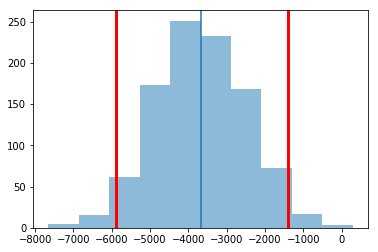

In [19]:
diffs = []
for i in range(n):
    sample = auto_price.sample(frac=1.0, replace=True)
    std_sample_mean = sample[sample['aspiration'] == 'std'].price.mean()
    turbo_sample_mean = sample[sample['aspiration'] == 'turbo'].price.mean()
    diffs.append(std_sample_mean - turbo_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

## Bayesian Method


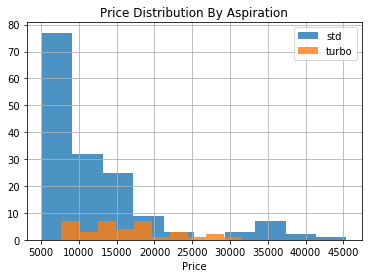

In [20]:
auto_price.loc[auto_price.loc[:,'aspiration'] == 'std', 'price'].hist(label = 'std', alpha =0.8)
auto_price.loc[auto_price.loc[:,'aspiration'] == 'turbo', 'price'].hist(label = 'turbo', alpha = 0.8)
plt.xlabel('Price')
plt.title('Price Distribution By Aspiration')
plt.legend()

Mean = 11332.250, Standard deviation = 6920.312
Mean = 16254.806, Standard deviation = 6093.183
The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


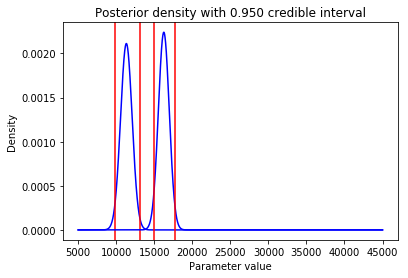

In [21]:
N = 10000
p = np.linspace(5000, 45000, num=N)

num_samples = 36

std =  auto_price.loc[auto_price.loc[:,'aspiration'] == 'std', :]
turbo = auto_price.loc[auto_price.loc[:,'aspiration'] == 'turbo', :]
std = std.sample(n=num_samples)
turbo = turbo.sample(n=num_samples)

like_std = comp_like(p, std.price)
pp_std = scipy.stats.norm.pdf(p, loc = std.price.mean() , scale=1000)
pp_std = pp_std/pp_std.sum()
post_std = posterior(pp_std, like_std)

like_turbo = comp_like(p, turbo.price)
pp_turbo = scipy.stats.norm.pdf(p, loc = turbo.price.mean(), scale=1000)
pp_turbo = pp_turbo/pp_turbo.sum()
post_turbo = posterior(pp_turbo, like_turbo)

# Plotting the Posterior distributions and CIs
plot_ci(p, post_std, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_turbo, num_samples, lower_q=.025, upper_q=.975)

According to the bayesian difference in means, we can reject the null hypothesis. The confidence intervals for std and turbo do not overlap.

After seeing the results of all 3 tests, 1 cannot reject the null hypothesis, and 2 reject the null hypothesis.

# Number of Cylinders 
For num-of-cylinders I will compare 4, vs 6 cylinders. There are also 4 other possible values for cylinders, but I will compare the most common two. 

In [22]:
auto_price['num-of-cylinders'].value_counts()

four      155
six        24
five       10
eight       4
three       1
twelve      1
Name: num-of-cylinders, dtype: int64

In [23]:
cylinders = auto_price[['num-of-cylinders', 'price']]

cylinders = cylinders[cylinders['num-of-cylinders'] != 'five']
cylinders = cylinders[cylinders['num-of-cylinders'] != 'eight']
cylinders = cylinders[cylinders['num-of-cylinders'] != 'three']
cylinders = cylinders[cylinders['num-of-cylinders'] != 'twelve']

cylinders['num-of-cylinders'].value_counts()

four    155
six      24
Name: num-of-cylinders, dtype: int64

## T-Test (Classical)

In [24]:
cylinders_strata = stratify_by(cylinders, 'num-of-cylinders')
cylinders_strata.reset_index(inplace = True, drop = True)

The sample size of each strata in num-of-cylinders is 24


In [25]:
four = cylinders_strata.loc[cylinders_strata.loc[:, 'num-of-cylinders'] == 'four', 'price']
six = cylinders_strata.loc[cylinders_strata.loc[:, 'num-of-cylinders'] =='six', 'price']

The T-test below demonstrates that the differennce in means is statistically significant. The P-value is very close to 0, and the conidence interval does not include 0. The T-statistic is also very large. The difference in means is ~$12,000. Due to these statistics, we can reject the null hypothesis that the difference of means arrises from randomness

DegFreedom    3.205320e+01
Difference   -1.399046e+04
Statistic    -7.054697e+00
PValue        5.283170e-08
Low95CI      -1.802972e+04
High95CI     -9.951196e+03
dtype: float64


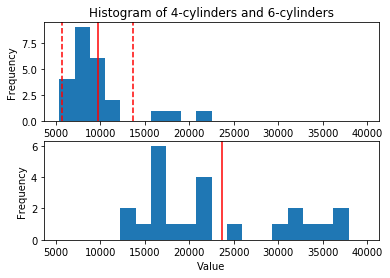

In [26]:
test = t_test(four, six, 0.05)
print(test)
plot_t(four, six, test, cols = ['4-cylinders', '6-cylinders'])

## Bootstrap
Now we compare the difference of means of two cylinder types using the Bootstrap method

In [27]:
four =  cylinders[cylinders['num-of-cylinders'] == 'four']
six = cylinders[cylinders['num-of-cylinders'] == 'six']

In [28]:
n = 1000

four_boot_mean = pd.Series([
    four.sample(frac=1, replace=True).price.mean()
    for i in range(n)
])

six_boot_mean = pd.Series([
    six.sample(frac=1, replace = True).price.mean()
    for i in range(n)
])

The difference of the boostrap means do not overlap. The confidence intervals do not overlap. We can reject the null hypothesis that the difference in price for number of cylinders is due to randomness. The difference in means between the 4-cylinder model ad the 6-cylinder model appears to be ~$13,000. This is statistically significant.

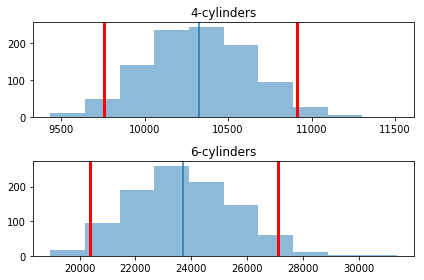

In [29]:
plot_dists(four_boot_mean, six_boot_mean, nbins=80, a_label='4-cylinders', b_label='6-cylinders')

The plot below is a bootstrap difference in means. It shows that the 4-cylinder price can be 10,000 to 17,000dollars less than a 6-cylinder price. This confidence interval does not overlap 0, meaning the difference in means is significant. 

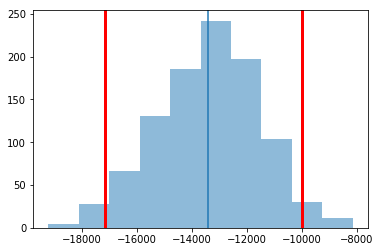

In [30]:
diffs = []
for i in range(n):
    sample = cylinders.sample(frac=1.0, replace=True)
    four_sample_mean = sample[sample['num-of-cylinders'] == 'four'].price.mean()
    six_sample_mean = sample[sample['num-of-cylinders'] == 'six'].price.mean()
    diffs.append(four_sample_mean - six_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

## Bayesian Method

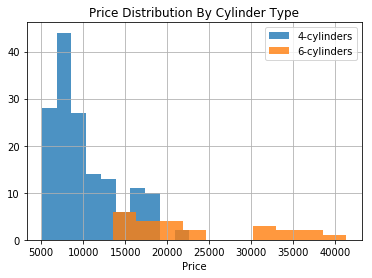

In [31]:
four.price.hist(label = '4-cylinders', alpha =0.8)
six.price.hist(label = '6-cylinders', alpha = 0.8)
plt.xlabel('Price')
plt.title('Price Distribution By Cylinder Type')
plt.legend()

Mean = 9573.375, Standard deviation = 3068.266
Mean = 23671.833, Standard deviation = 8663.799
The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


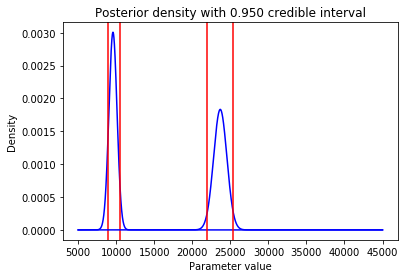

In [32]:
N = 10000
p = np.linspace(5000, 45000, num=N)

num_samples = 24
four =  cylinders[cylinders['num-of-cylinders'] == 'four']
six = cylinders[cylinders['num-of-cylinders'] == 'six']
four = four.sample(n=num_samples)
six = six.sample(n=num_samples)

like_four = comp_like(p, four.price)
pp_four = scipy.stats.norm.pdf(p, loc = four.price.mean() , scale=1000)
pp_four = pp_four/pp_four.sum()
post_four = posterior(pp_four, like_four)

like_six = comp_like(p, six.price)
pp_six = scipy.stats.norm.pdf(p, loc = six.price.mean(), scale=1000)
pp_six = pp_six/pp_six.sum()
post_six = posterior(pp_six, like_six)

# Plotting the Posterior distributions and CIs
plot_ci(p, post_four, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_six, num_samples, lower_q=.025, upper_q=.975)

The Bayesian method shows the posterier densities of 4, and 6 cylinder vehicles. The graph demonstrates that the distributions do not overlap, and the confidence intervals do not overlap. Due to these reasons, we can reject the null hypothesis that the difference of means of the two cylinders arrises from randomness.

This example shows that all tree tests reject the null hypothesis. 

# Number of Doors
We will see if there is a difference in means between two and four door cars.

In [33]:
auto_price['num-of-doors'].value_counts()

four    112
two      81
?         2
Name: num-of-doors, dtype: int64

In [34]:
doors = auto_price[['num-of-doors','price']]
doors = doors[doors['num-of-doors'] != '?']
doors['num-of-doors'].value_counts()

four    112
two      81
Name: num-of-doors, dtype: int64

## T-Test(Classical)

In [35]:
doors_strata = stratify_by(doors, 'num-of-doors')
doors_strata.reset_index(drop = True, inplace = True)

The sample size of each strata in num-of-doors is 81


In [36]:
two_doors = doors_strata.loc[doors_strata.loc[:,'num-of-doors'] == 'two','price']
four_doors = doors_strata.loc[doors_strata.loc[:,'num-of-doors'] == 'four','price']

The t-test below shows that we cannot reject the null hypothesis. The p-value is very high and the confidence interval straddles 0. 

The histogram demonstrates the the mean of a 4 door car is within the confidence interval. 

DegFreedom     157.586862
Difference    -996.592593
Statistic       -0.749093
PValue           0.454918
Low95CI      -3624.305498
High95CI      1631.120312
dtype: float64


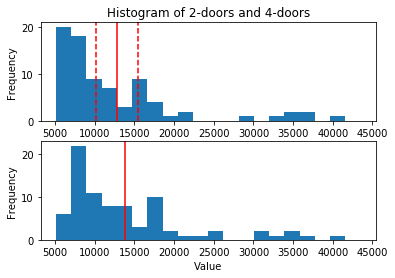

In [37]:
test = t_test(two_doors, four_doors, 0.05)
print(test)
plot_t(two_doors, four_doors, test, cols = ['2-doors', '4-doors'])

## Bootstrap

In [38]:
#creating two objects for each door style
two_doors = doors.loc[doors.loc[:, 'num-of-doors'] == 'two',:]
four_doors = doors.loc[doors.loc[:, 'num-of-doors'] =='four', :]

In [39]:
n = 1000

four_boot_mean = pd.Series([
    four_doors.sample(frac=1, replace=True).price.mean()
    for i in range(n)
])

two_boot_mean = pd.Series([
    two_doors.sample(frac=1, replace = True).price.mean()
    for i in range(n)
])

The histograms below show that the means are very close, and the confidence intervals for the two distributions overlap.

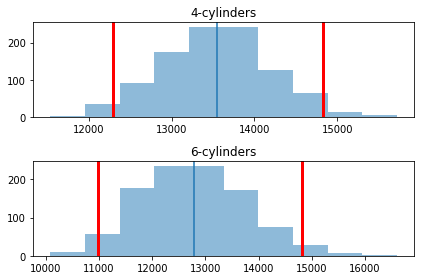

In [40]:
plot_dists(four_boot_mean, two_boot_mean, nbins=80, a_label='4-cylinders', b_label='6-cylinders')

The confidence interval for difference in means straddles 0. We cannot reject the null hypothesis that the diference in means for number of car doors arrises from randomness. 

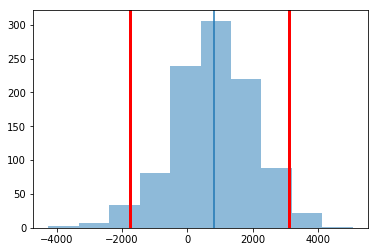

In [41]:
diffs = []
for i in range(n):
    sample = doors.sample(frac=1.0, replace=True)
    four_sample_mean = sample[sample['num-of-doors'] == 'four'].price.mean()
    two_sample_mean = sample[sample['num-of-doors'] == 'two'].price.mean()
    diffs.append(four_sample_mean - two_sample_mean)
diffs = pd.Series(diffs)

plot_hist(diffs)

## Bayesian Method

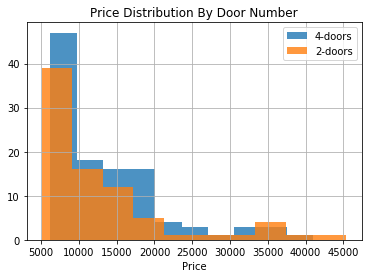

In [42]:
four_doors.price.hist(label = '4-doors', alpha =0.8)
two_doors.price.hist(label = '2-doors', alpha = 0.8)
plt.xlabel('Price')
plt.title('Price Distribution By Door Number')
plt.legend()

Mean = 13603.804, Standard deviation = 7375.002
Mean = 12844.247, Standard deviation = 8919.610
The 0.950 credible interval is 0.025 to 0.975
The 0.950 credible interval is 0.025 to 0.975


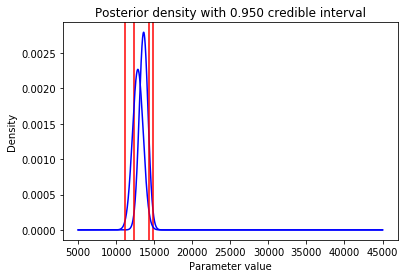

In [43]:
N = 10000
p = np.linspace(5000, 45000, num=N)
num_samples = 80

four = doors[doors['num-of-doors'] == 'four']
two = doors[doors['num-of-doors'] == 'two']


like_four = comp_like(p, four.price)
pp_four = scipy.stats.norm.pdf(p, loc = four.price.mean() , scale=1000)
pp_four = pp_four/pp_four.sum()
post_four = posterior(pp_four, like_four)

like_two = comp_like(p, two.price)
pp_two = scipy.stats.norm.pdf(p, loc = two.price.mean(), scale=1000)
pp_two = pp_two/pp_two.sum()
post_two = posterior(pp_two, like_two)

# Plotting the Posterior distributions and CIs
plot_ci(p, post_four, num_samples, lower_q=.025, upper_q=.975)
plot_ci(p, post_two, num_samples, lower_q=.025, upper_q=.975)

The bayes method shows that the posterior distributions for both numbers of car doors overlap. Their confidence intrervals have a big overlap. We cannot rejct the null hypothesis 

All three tests show that we cannot reject the null hypothesis for number of doors. There isn't a significance in the difference in means for number of car doors. 

# Tukey HSD Test 

The box plot below shows the means and distributions of price by body style.

Text(0.5, 0, 'Body Style')

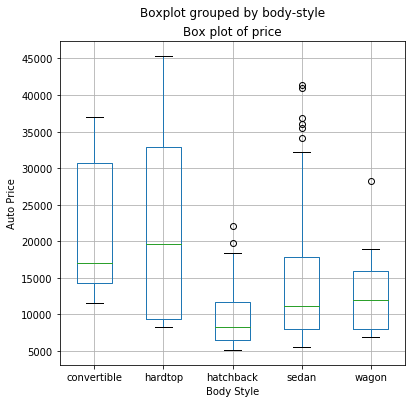

In [44]:
body_style = auto_price.groupby(['body-style'])


fig = plt.figure(figsize=(6, 6)) 
ax = fig.gca() 
auto_price.loc[:,['price', 'body-style']].boxplot(by = 'body-style', ax = ax)
ax.set_title('Box plot of price') 
ax.set_ylabel('Auto Price')
ax.set_xlabel('Body Style')

## Tukey HS Test

The Tukey HS Test allows us to compare te different body styles by pairs, which is more accurate. The ANOVA test merely gave us a statistic that not all the styles have overlapping means.

The table below shows us 4 instances where we cannot reject the null hypothesis. In these rows, we can see the confidence interval straddling 0. 

In [45]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

hsd = pairwise_tukeyhsd(auto_price.loc[:, 'price'], auto_price.loc[:, 'body-style'])
print(hsd)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
   group1     group2    meandiff     lower      upper    reject
---------------------------------------------------------------
convertible  hardtop     318.0    -10784.1247 11420.1247 False 
convertible hatchback -12126.5159 -20909.4848 -3343.5469  True 
convertible   sedan    -7430.7447 -16086.8623  1225.373  False 
convertible   wagon    -9390.3333 -18773.3413  -7.3254    True 
  hardtop   hatchback -12444.5159 -20160.2385 -4728.7932  True 
  hardtop     sedan    -7748.7447 -15319.7555 -177.7338   True 
  hardtop     wagon    -9708.3333 -18100.7508 -1315.9159  True 
 hatchback    sedan    4695.7712   1348.5969  8042.9455   True 
 hatchback    wagon    2736.1825   -2194.9472 7667.3123  False 
   sedan      wagon    -1959.5887  -6661.0639 2741.8866  False 
---------------------------------------------------------------


Visually it is very easy to see there are 4 instances where the intervals overlap. We cannot reject the null hypothesis, that the difference of means arises from randomness, for pairs where the confidence intervals overlap. 

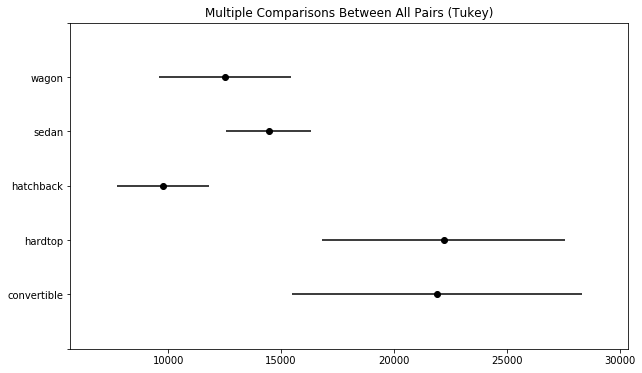

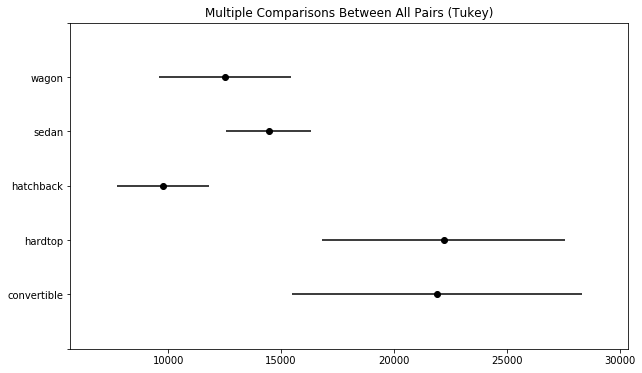

In [46]:
hsd.plot_simultaneous()